# Градиентный бустинг (Регрессия)

Проведите регрессию методом Градиентного бустинга. Обратите внимание на подбор гиперпараметров алгоритма. Качество оценить минимум по 3 критериям качества для регрессии: MAE, MSE, RMSE, MAPE, RMSLE, R^2 и др.

**Описание набора данных:**

- Age: Возраст застрахованного лица (Numerical)
- Gender: Пол застрахованного лица (Categorical: Male, Female)
- Annual Income: Годовой доход застрахованного лица (Numerical, skewed)
- Marital Status: Семейное положение застрахованного лица (Categorical: Single, Married, Divorced)
- Number of Dependents: Количество иждивенцев (Numerical, with missing values)
- Education Level: Наивысший достигнутый уровень образования (Categorical: High School, Bachelor's, Master's, PhD)
- Occupation: Род занятий застрахованного лица (Categorical: Employed, Self-Employed, Unemployed)
- Health Score: оценка, отражающая состояние здоровья (Numerical, skewed)
- Location: Тип местоположения (Categorical: Urban, Suburban, Rural)
- Policy Type: Тип страхового полиса (Categorical: Basic, Comprehensive, Premium)
- Previous Claims: Количество предыдущих заявлений (Numerical, with outliers)
- Vehicle Age: Возраст застрахованного транспортного средства (Numerical)
- Credit Score: Кредитный рейтинг застрахованного лица (Numerical, with missing values)
- Insurance Duration: Срок действия страхового полиса (Numerical, in years)
- Policy Start Date: Дата начала действия страхового полиса (Text, improperly formatted)
- Customer Feedback: Краткие отзывы клиентов (Text)
- Smoking Status: Статус курения застрахованного лица (Categorical: Yes, No)
- Exercise Frequency: Частота упражнений (Categorical: Daily, Weekly, Monthly, Rarely)
- Property Type: Тип собственности (Categorical: House, Apartment, Condo)


- Premium Amount: Целевая переменная, представляющая сумму страховой премии (Numerical, skewed)


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

## Проведем EDA (Exploratory Data Analysis) - первичный анализ данных

In [4]:
# Функция для числовых столбцов
def eda_num_info(df):
    x = pd.DataFrame(
        {
            "Доля пропусков": df.isnull().mean(),
            "Минимальное значение": df.min(),
            "Максимальное значение": df.max(),
            "Среднее значение": df.mean(),
            "Медиана": df.median(),
            "Дисперсия": df.var(),
            "Квантиль 0.1": df.quantile(0.1),
            "Квантиль 0.9": df.quantile(0.9),
            "Квартиль 1": df.quantile(0.25),
            "Квартиль 3": df.quantile(0.75)
        }
    )
    
    return x

In [5]:
# Функция для категориальных столбцов
def eda_cat_info(df):
    x = pd.DataFrame(
        {
            "Доля пропусков": df.isnull().mean(),
            "Количество уникальных значений": df.nunique(),
            "Мода": df.mode().iloc[0]
        }
    )
    
    return x

In [6]:
col_num = df.select_dtypes(include=["number"]).columns
eda_num_info(df[col_num])

,Доля пропусков,Минимальное значение,Максимальное значение,Среднее значение,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
id,0.000000e+00,0.000000,1.199999e+06,599999.500000,599999.500000,1.200001e+11,119999.900000,1.079999e+06,299999.750000,899999.250000
Age,1.558750e-02,18.000000,6.400000e+01,41.145563,41.000000,1.833302e+02,22.000000,6.000000e+01,30.000000,53.000000
Annual Income,3.745750e-02,1.000000,1.499970e+05,32745.217777,23911.000000,1.035521e+09,2627.000000,8.107500e+04,8001.000000,44634.000000
Number of Dependents,9.139333e-02,0.000000,4.000000e+00,2.009934,2.000000,2.008846e+00,0.000000,4.000000e+00,1.000000,3.000000
Health Score,6.173000e-02,2.012237,5.897591e+01,25.613908,24.578648,1.489245e+02,9.936849,4.328134e+01,15.918959,34.527209
Previous Claims,3.033575e-01,0.000000,9.000000e+00,1.002689,1.000000,9.659748e-01,0.000000,2.000000e+00,0.000000,2.000000
Vehicle Age,5.000000e-06,0.000000,1.900000e+01,9.569889,10.000000,3.336436e+01,2.000000,1.800000e+01,5.000000,15.000000
Credit Score,1.149017e-01,300.000000,8.490000e+02,592.924350,595.000000,2.249458e+04,383.000000,7.920000e+02,468.000000,721.000000
Insurance Duration,8.333333e-07,1.000000,9.000000e+00,5.018219,5.000000,6.730555e+00,1.000000,9.000000e+00,3.000000,7.000000
Premium Amount,0.000000e+00,20.000000,4.999000e+03,1102.544822,872.000000,7.482230e+05,150.000000,2.363000e+03,514.000000,1509.000000


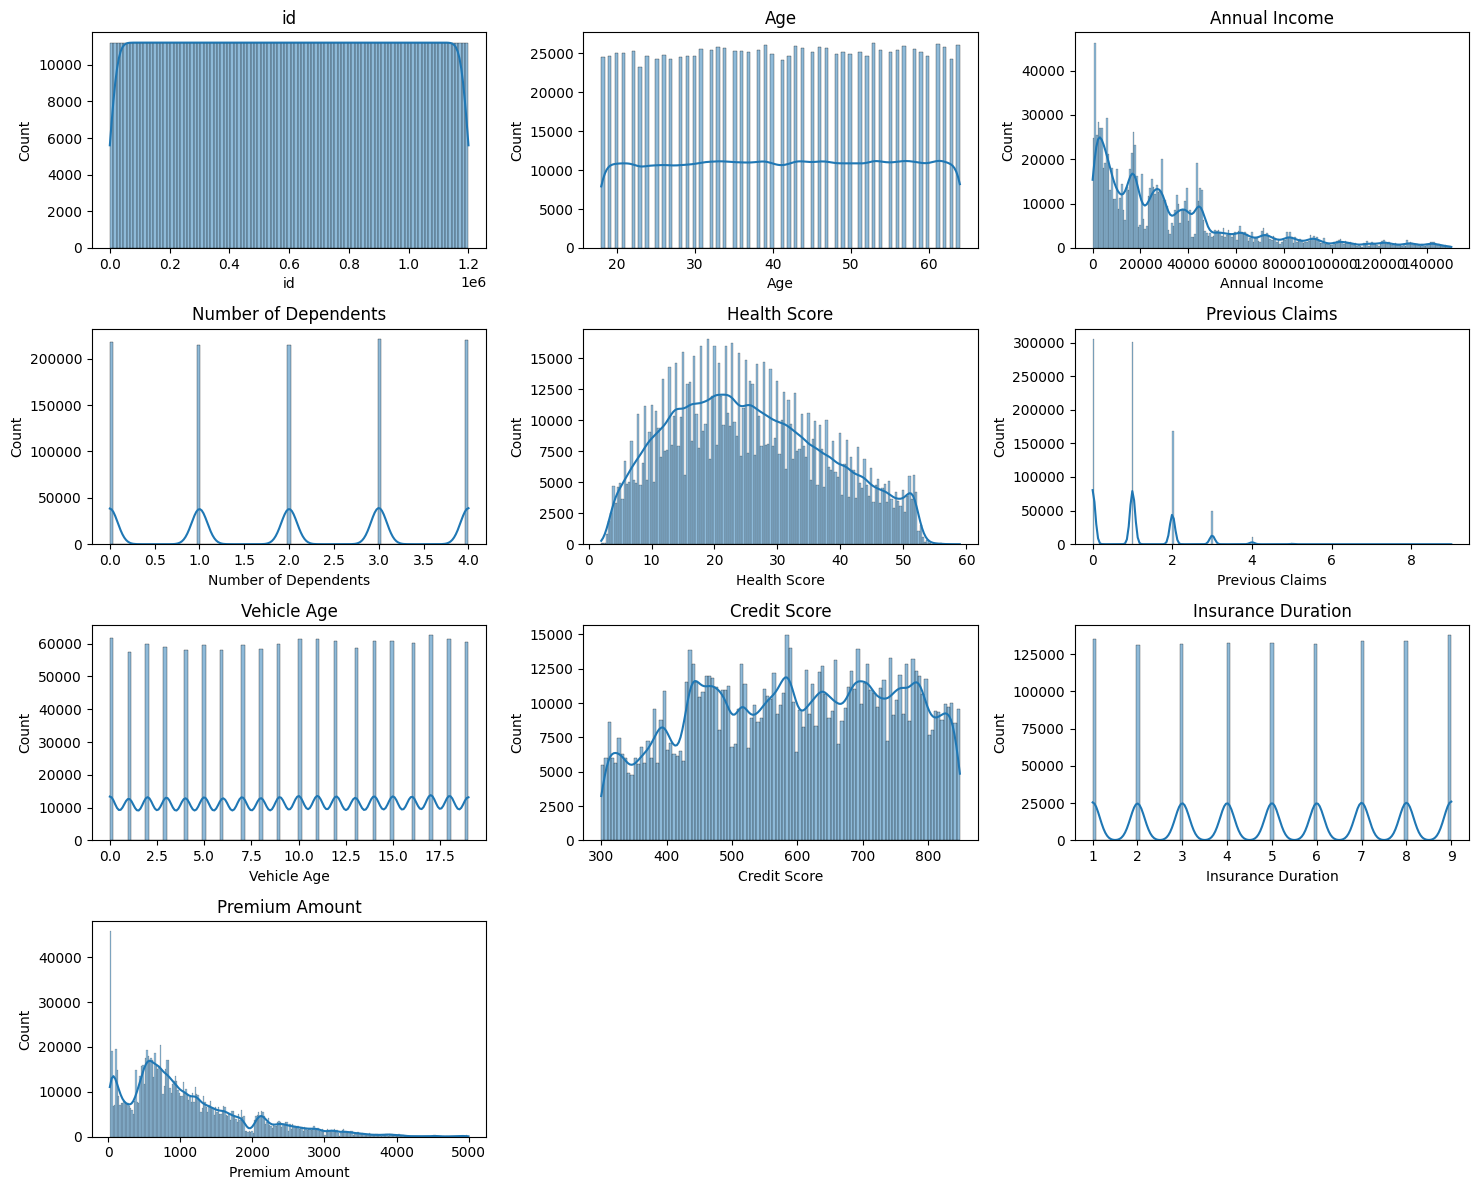

In [7]:
# Визуализация гистограмм
def plot_histograms(df):
    # Определить количество строк и столбцов для подграфиков
    n_cols = 3
    n_rows = (len(df.columns) + n_cols - 1) // n_cols
    
    # Создать фигуру с нужным размером
    plt.figure(figsize=(n_cols * 5, n_rows * 3))
    
    for i, column in enumerate(df.columns, start=1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[column], kde=True)
        
        # Добавить название столбца как заголовок графика
        plt.title(column)
        
    plt.tight_layout()
    plt.show()

# Применение функции к DataFrame df
plot_histograms(df[col_num])

In [8]:
col_cat = df.select_dtypes(include=["object"]).columns
eda_cat_info(df[col_cat])

,Доля пропусков,Количество уникальных значений,Мода
Gender,0.000000,2,Male
Marital Status,0.015441,3,Single
Education Level,0.000000,4,Master's
Occupation,0.298396,3,Employed
Location,0.000000,3,Suburban
Policy Type,0.000000,3,Premium
Policy Start Date,0.000000,167381,2020-02-08 15:21:39.134960
Customer Feedback,0.064853,3,Average
Smoking Status,0.000000,2,Yes
Exercise Frequency,0.000000,4,Weekly


Данные столбца *Policy Start Date* - дата начала действия страхового полиса - будет сложно использовать при обучении модели регрессии, поэтому данный столбец удалим. По остальным столбцам видно, что имеются пропуски, будем исправлять.

In [9]:
df = df.drop(columns=["Policy Start Date"])

In [10]:
col_cat = df.select_dtypes(include=["object"]).columns
eda_cat_info(df[col_cat])

,Доля пропусков,Количество уникальных значений,Мода
Gender,0.000000,2,Male
Marital Status,0.015441,3,Single
Education Level,0.000000,4,Master's
Occupation,0.298396,3,Employed
Location,0.000000,3,Suburban
Policy Type,0.000000,3,Premium
Customer Feedback,0.064853,3,Average
Smoking Status,0.000000,2,Yes
Exercise Frequency,0.000000,4,Weekly
Property Type,0.000000,3,House


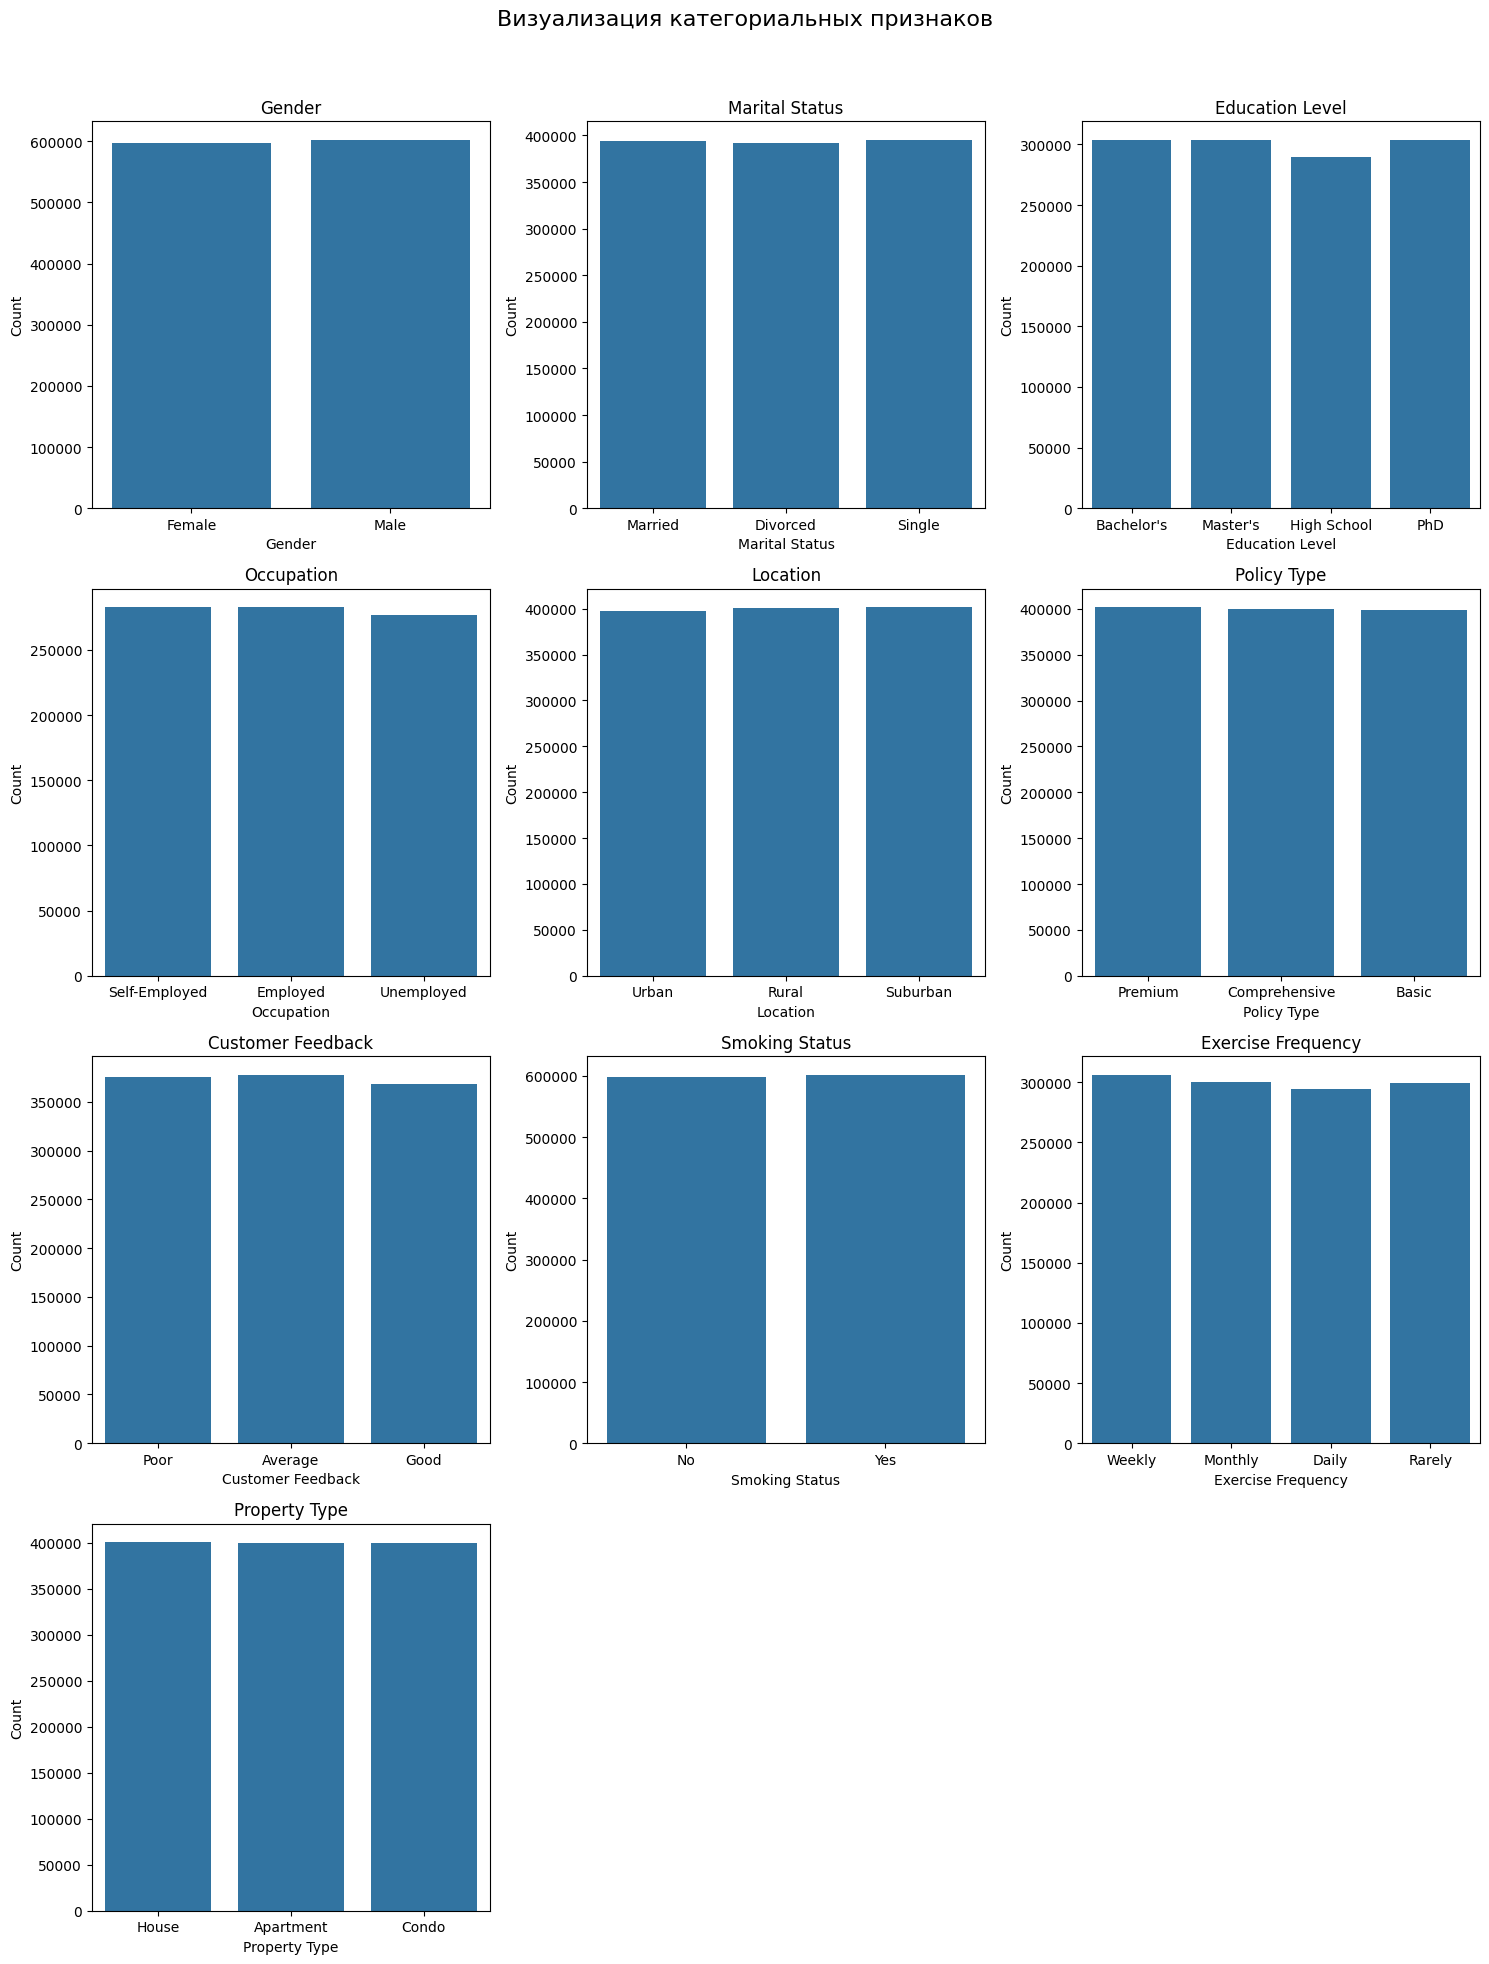

In [11]:
# Определение количества строк и столбцов для сетки
n = len(col_cat)
ncols = 3  # Количество столбцов в сетке
nrows = (n + ncols - 1) // ncols  # Количество строк

# Создание фигуры и подграфиков
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Преобразование в одномерный массив для удобства

# Создание столбчатой диаграммы для каждого категориального столбца
for i, column in enumerate(col_cat):
    sns.countplot(data=df, x=column, ax=axes[i])
    axes[i].set_title(column)  # Заголовок для каждого графика
    axes[i].set_xlabel(column)  # Подпись оси X
    axes[i].set_ylabel('Count')  # Подпись оси Y

# Удаление пустых подграфиков, если они есть
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Добавление заголовка к сетке графиков
fig.suptitle('Визуализация категориальных признаков', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Автоматическая настройка отступов
plt.show()  # Отображение графиков

## Подготовка датасета к построению моделей ML

### Целевая переменная

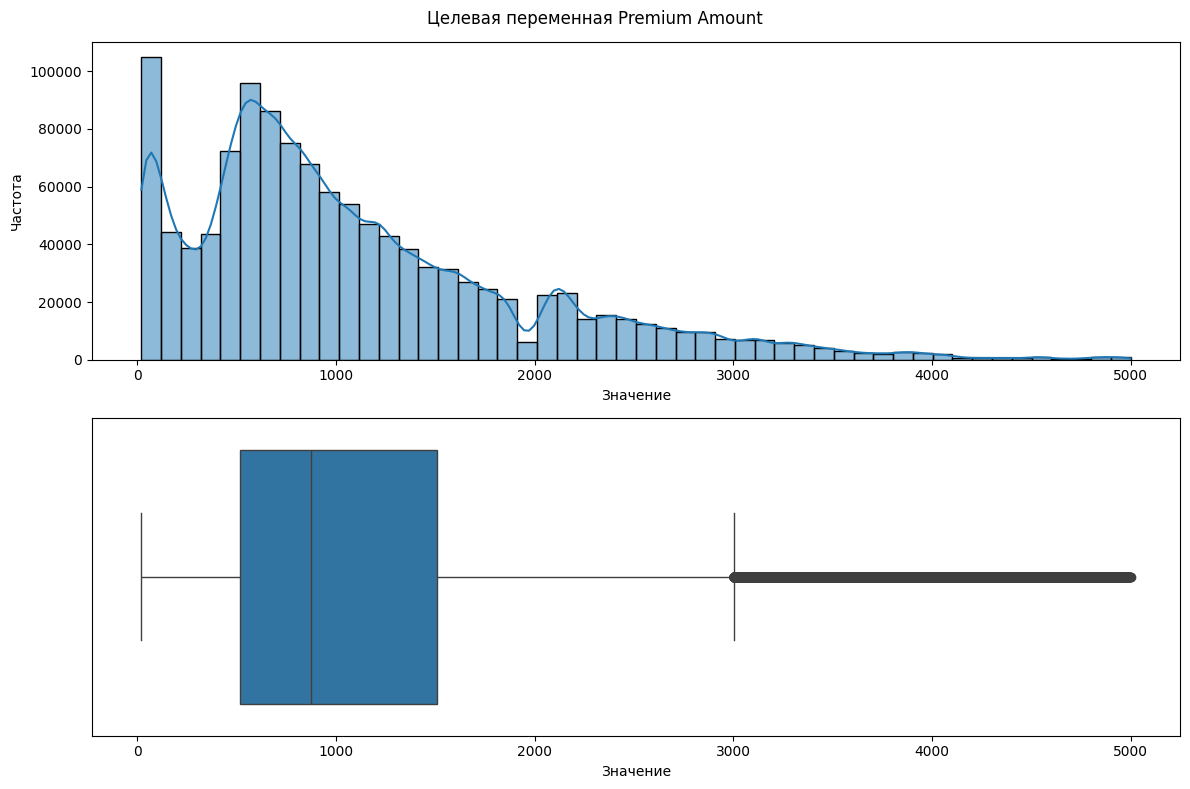

In [12]:
# Распределение целевой переменной
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.histplot(df['Premium Amount'], bins=50, kde=True, ax=ax[0])
ax[0].set_xlabel("Значение")
ax[0].set_ylabel("Частота")

sns.boxplot(df['Premium Amount'], orient="h", ax=ax[1])
ax[1].set_xlabel("Значение")
ax[1].set_yticks([])

plt.suptitle("Целевая переменная Premium Amount")
plt.tight_layout()
plt.show()

Видим, что имеются выбросы, но если их удалить, то потеряется достаточно много полезной информации. Оставим как есть.

### Обработка пропусков

In [13]:
print("Количество пропусков в числовых столбцах:")
print(df[col_num].isnull().sum())
print("\nКоличество пропусков в категориальных столбцах:")
print(df[col_cat].isnull().sum())

Количество пропусков в числовых столбцах:
id                           0
Age                      18705
Annual Income            44949
Number of Dependents    109672
Health Score             74076
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Premium Amount               0
dtype: int64

Количество пропусков в категориальных столбцах:
Gender                     0
Marital Status         18529
Education Level            0
Occupation            358075
Location                   0
Policy Type                0
Customer Feedback      77824
Smoking Status             0
Exercise Frequency         0
Property Type              0
dtype: int64


In [14]:
# Заполняем пропуски числовых переменных медианой
df[col_num] = df[col_num].fillna(df[col_num].median())

In [15]:
# Заполненяем пропуски модой для категориальных столбцов
for column in col_cat:
    mode_value = df[column].mode()[0]  # Получение моды
    df.fillna({column: mode_value}, inplace=True)  # Заполнение пропусков модой

In [16]:
print("Количество пропусков в числовых столбцах:")
print(df[col_num].isnull().sum())
print("\nКоличество пропусков в категориальных столбцах:")
print(df[col_cat].isnull().sum())

Количество пропусков в числовых столбцах:
id                      0
Age                     0
Annual Income           0
Number of Dependents    0
Health Score            0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Premium Amount          0
dtype: int64

Количество пропусков в категориальных столбцах:
Gender                0
Marital Status        0
Education Level       0
Occupation            0
Location              0
Policy Type           0
Customer Feedback     0
Smoking Status        0
Exercise Frequency    0
Property Type         0
dtype: int64


### Обработка выбросов

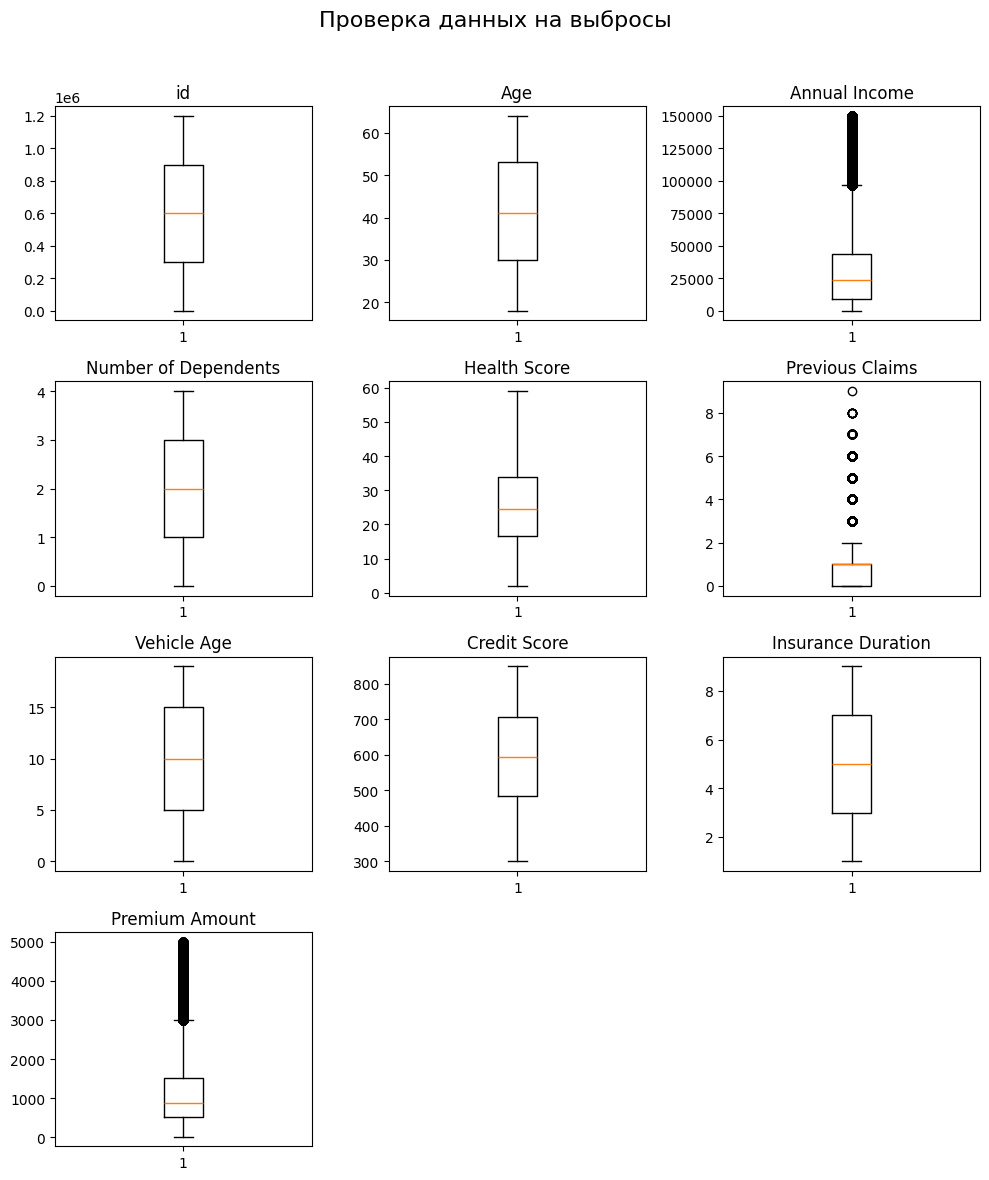

In [17]:
n = len(col_num)
ncols = 3  # Количество столбцов в сетке
nrows = (n + ncols - 1) // ncols  # Количество строк

# Создание фигуры и подграфиков
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3 * nrows))
axes = axes.flatten()  # Преобразование в одномерный массив для удобства

# Создание boxplot для каждого числового столбца
for i, column in enumerate(col_num):
    axes[i].boxplot(df[column])
    axes[i].set_title(column)  # Заголовок для каждого графика

# Удаление пустых подграфиков, если они есть
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
fig.suptitle("Проверка данных на выбросы", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Автоматическая настройка отступов
plt.show()  # Отображение графиков

In [18]:
df['Annual Income'].sort_values(ascending=False).head()

427875    149997.0
167855    149997.0
585837    149996.0
111026    149996.0
88801     149996.0
Name: Annual Income, dtype: float64

In [19]:
df['Annual Income'].sort_values().head()

1013454    1.0
522743     2.0
655980     2.0
63472      2.0
571779     2.0
Name: Annual Income, dtype: float64

In [20]:
df['Previous Claims'].sort_values().unique()

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

Большое количество выбросов видно в столбце *Annual Income*. Значения принимаются от 1 до 149997. Заменим выбросы с помощью помощью метода интерквантильного размаха. Столбец *Previus Claims* оставим без изменений, видим что там идет нормальное распределение значений.

In [21]:
# Обработаем выбросы
def outliers_in_data(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = df[col].quantile(0.1)
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    
    return df


df = outliers_in_data(df, ['Annual Income'])

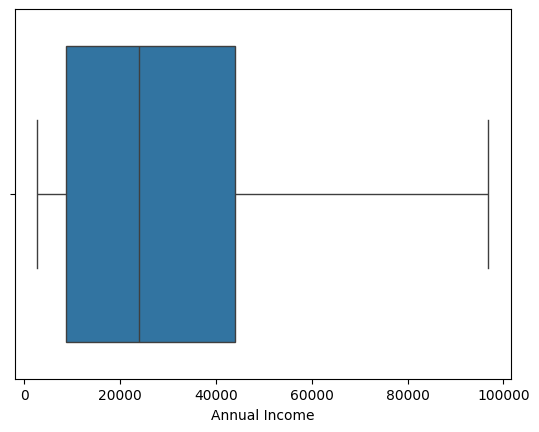

In [22]:
sns.boxplot(data=df, x='Annual Income')
plt.show()

In [23]:
df['Annual Income'].sort_values(ascending=False).head()

329780    96871.0
205017    96871.0
995192    96871.0
398614    96871.0
995189    96871.0
Name: Annual Income, dtype: float64

In [24]:
df['Annual Income'].sort_values().head()

924112     2699.0
1019079    2699.0
96617      2699.0
96616      2699.0
363402     2699.0
Name: Annual Income, dtype: float64

## Проведем EDA после обработки данных

In [25]:
eda_num_info(df[col_num])

,Доля пропусков,Минимальное значение,Максимальное значение,Среднее значение,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
id,0.0,0.000000,1.199999e+06,599999.500000,599999.500000,1.200001e+11,119999.900000,1.079999e+06,299999.750000,899999.25000
Age,0.0,18.000000,6.400000e+01,41.143294,41.000000,1.804729e+02,22.000000,6.000000e+01,30.000000,53.00000
Annual Income,0.0,2699.000000,9.687100e+04,31122.853124,23911.000000,7.576032e+08,2699.000000,7.944810e+04,8646.000000,43936.00000
Number of Dependents,0.0,0.000000,4.000000e+00,2.009026,2.000000,1.825259e+00,0.000000,4.000000e+00,1.000000,3.00000
Health Score,0.0,2.012237,5.897591e+01,25.550001,24.578648,1.397934e+02,10.185439,4.284583e+01,16.554572,33.77289
Previous Claims,0.0,0.000000,9.000000e+00,1.001873,1.000000,6.729404e-01,0.000000,2.000000e+00,0.000000,1.00000
Vehicle Age,0.0,0.000000,1.900000e+01,9.569891,10.000000,3.336419e+01,2.000000,1.800000e+01,5.000000,15.00000
Credit Score,0.0,300.000000,8.490000e+02,593.162846,595.000000,1.991035e+04,393.000000,7.870000e+02,484.000000,706.00000
Insurance Duration,0.0,1.000000,9.000000e+00,5.018219,5.000000,6.730550e+00,1.000000,9.000000e+00,3.000000,7.00000
Premium Amount,0.0,20.000000,4.999000e+03,1102.544822,872.000000,7.482230e+05,150.000000,2.363000e+03,514.000000,1509.00000


In [26]:
eda_cat_info(df[col_cat])

,Доля пропусков,Количество уникальных значений,Мода
Gender,0.0,2,Male
Marital Status,0.0,3,Single
Education Level,0.0,4,Master's
Occupation,0.0,3,Employed
Location,0.0,3,Suburban
Policy Type,0.0,3,Premium
Customer Feedback,0.0,3,Average
Smoking Status,0.0,2,Yes
Exercise Frequency,0.0,4,Weekly
Property Type,0.0,3,House


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1200000 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1200000 non-null  float64
 4   Marital Status        1200000 non-null  object 
 5   Number of Dependents  1200000 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            1200000 non-null  object 
 8   Health Score          1200000 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       1200000 non-null  float64
 12  Vehicle Age           1200000 non-null  float64
 13  Credit Score          1200000 non-null  float64
 14  Insurance Duration    1200000 non-

Пропуски и выбросы обработаны.

## Построим матрицу корреляций

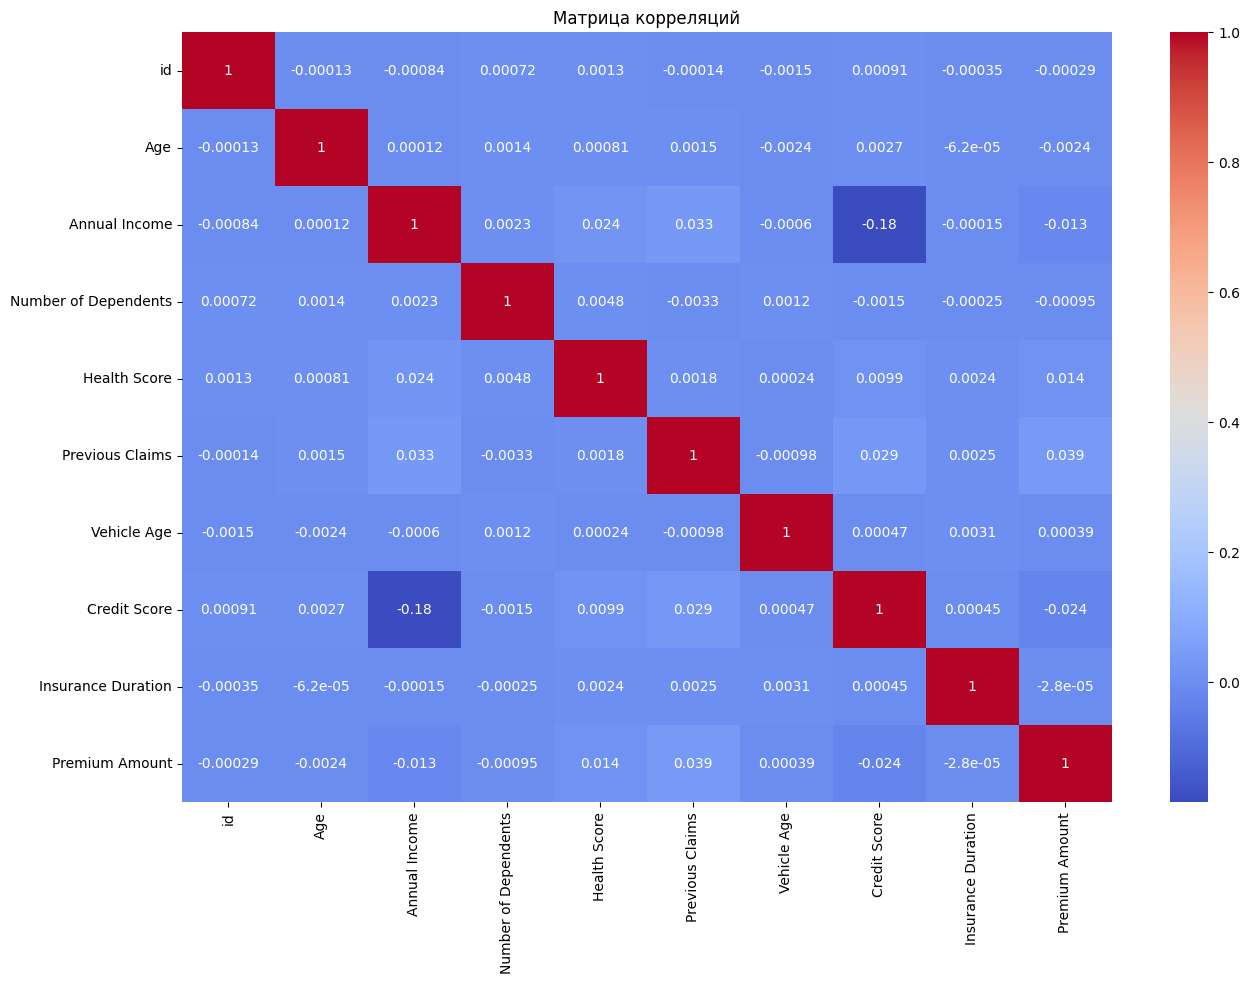

In [28]:
corr = df[col_num].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Матрица корреляций")
plt.show()

Явных корреляций не заметно.

## Уменьшаем исходный датасет

**Для удобства и скорости расчетов уменьшим исходный датафрейм в 10 раз:**

- `Квантильная группировка`: Используем *pd.qcut* для разделения целевой переменной на 10 квантильных групп.

- `Стратифицированная выборка`: Для каждой квантильной группы выбираем 10% данных, сохраняя пропорции.

Таким образом мы получаем уменьшенную копию нашего датасета.

In [29]:
df['Premium_Amount_quantile'] = pd.qcut(df['Premium Amount'], q=10, labels=False)

In [30]:
def stratified_sample(group):
    return group.sample(frac=0.1, random_state=42)

In [31]:
df_short = df.groupby('Premium_Amount_quantile').apply(stratified_sample).reset_index(drop=True)

# Выводим информацию о новом датасете
print("Исходный размер датасета:", df.shape)
print("Размер уменьшенного датасета:", df_short.shape)
print("Распределение целевой переменной в начальном датасете:")
print(df['Premium Amount'].describe())
print("Распределение целевой переменной в уменьшенном датасете:")
print(df_short['Premium Amount'].describe())

Исходный размер датасета: (1200000, 21)
Размер уменьшенного датасета: (120000, 21)
Распределение целевой переменной в начальном датасете:
count    1.200000e+06
mean     1.102545e+03
std      8.649989e+02
min      2.000000e+01
25%      5.140000e+02
50%      8.720000e+02
75%      1.509000e+03
max      4.999000e+03
Name: Premium Amount, dtype: float64
Распределение целевой переменной в уменьшенном датасете:
count    120000.000000
mean       1102.362292
std         864.908820
min          20.000000
25%         514.000000
50%         872.000000
75%        1507.000000
max        4988.000000
Name: Premium Amount, dtype: float64


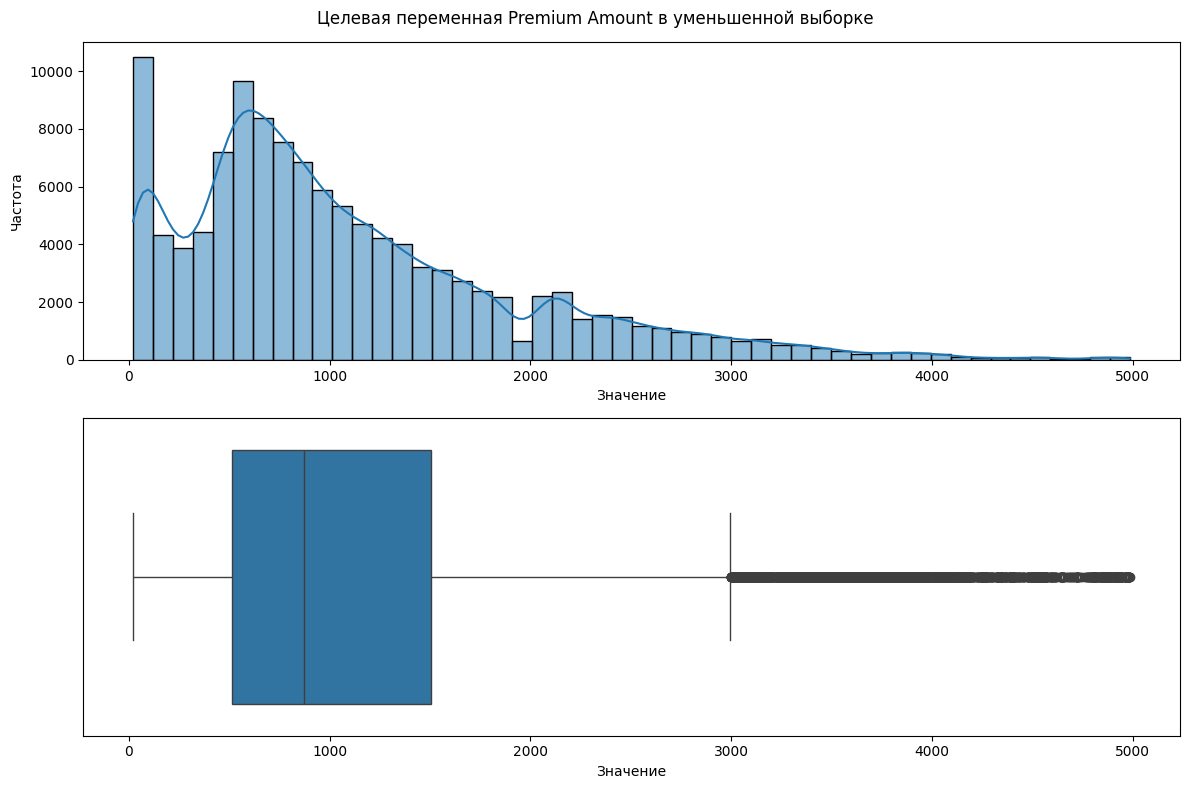

In [32]:
# Распределение целевой переменной
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.histplot(df_short['Premium Amount'], bins=50, kde=True, ax=ax[0])
ax[0].set_xlabel("Значение")
ax[0].set_ylabel("Частота")

sns.boxplot(df_short['Premium Amount'], orient="h", ax=ax[1])
ax[1].set_xlabel("Значение")
ax[1].set_yticks([])

plt.suptitle("Целевая переменная Premium Amount в уменьшенной выборке")
plt.tight_layout()
plt.show()

Графики распределения целевой переменной для полной и уменьшенной выборок идентичные.

## Кодирование категориальных столбцов

In [33]:
# Используем метод OneHotEncoding
df_short = pd.get_dummies(df_short, columns=col_cat, drop_first=True, dtype=int)

df_short.head()

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,9924,18.0,8773.0,3.0,36.352452,2.0,10.0,595.0,1.0,104.0,...,0,0,1,0,0,1,0,0,0,0
1,448793,47.0,23911.0,4.0,42.947791,2.0,4.0,784.0,5.0,25.0,...,0,1,0,0,1,0,0,1,0,1
2,259981,58.0,52848.0,2.0,20.099202,1.0,12.0,591.0,5.0,135.0,...,0,0,0,1,0,0,0,1,0,1
3,639001,47.0,6006.0,4.0,15.173677,2.0,19.0,595.0,3.0,22.0,...,0,1,1,0,0,0,0,0,0,1
4,138394,64.0,54786.0,0.0,11.958989,2.0,3.0,656.0,1.0,144.0,...,0,0,0,0,0,0,0,0,1,0


## Разделим на тренировочную и тестовую выборки

In [34]:
X = df_short.drop(columns=['id', 'Premium Amount', 'Premium_Amount_quantile'])
y = df_short['Premium Amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Размер тренировочной выборки (признаки):', X_train.shape)
print('Размер тестовой выборки (признаки):', X_test.shape)
print('Размер тренировочной выборки (целевой признак):', y_train.shape)
print('Размер тестовой выборки (целевой признак):', y_test.shape)

Размер тренировочной выборки (признаки): (96000, 28)
Размер тестовой выборки (признаки): (24000, 28)
Размер тренировочной выборки (целевой признак): (96000,)
Размер тестовой выборки (целевой признак): (24000,)


## Напишем функцию для подбора гиперпараметров и подсчета метрик

In [35]:
# Функция подбора гиперпараметров. Используем RandomizedSearchCV для скорости обучения
def hyperparameter_search(model, param_grid, X_train, y_train, n_iter=20, cv=5, scoring='neg_mean_squared_error'):
  
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv=cv,
                                       scoring=scoring, n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    
    print(f"Лучшие гиперпараметры для {model}: {random_search.best_params_}")
    
    best_model = random_search.best_estimator_
    return best_model

# Функция подсчета метрик
def evaluate_model(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    
    # Метрики
    metrics = {
        "MAE": round(mean_absolute_error(y_test, y_pred), 3),
        "MSE": round(mean_squared_error(y_test, y_pred), 3),
        "RMSE": round(root_mean_squared_error(y_test, y_pred), 3),
        "R2": round(r2_score(y_test, y_pred), 3)
    }
    
    return metrics, y_pred

# Функция визуализации важности признаков    
def plot_feature_importance(model, X, model_name):
    if hasattr(model, "feature_importances_"):
        feature_imp = pd.DataFrame(
            sorted(zip(model.feature_importances_, X.columns)),
            columns=['Важность признака', 'Признак']
        )
        plt.figure(figsize=(10, 10))
        sns.barplot(x="Важность признака", y="Признак", data=feature_imp.sort_values(by="Важность признака", ascending=False))
        plt.title(f'Важность признака для {model_name}')
        plt.tight_layout()
        plt.grid()
        plt.show()
    else:
        print("Модель не поддерживает feature_importances_")

## DecisionTreeRegressor

In [36]:
param_grid_dt = {
    'max_depth': [None] + [i for i in range(1, 10, 2)],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'ccp_alpha': [0.01, 0.02, 0.03]
}

In [37]:
%%time

model_dt = DecisionTreeRegressor(random_state=42)     
best_model_dt = hyperparameter_search(model_dt, param_grid_dt, X_train, y_train)
metrics_dt, y_pred_dt = evaluate_model(best_model_dt, X_test, y_test)

Лучшие гиперпараметры для DecisionTreeRegressor(random_state=42): {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 7, 'ccp_alpha': 0.03}
CPU times: total: 5.27 s
Wall time: 9.48 s


In [38]:
# Подсчет метрик
df_metrics_dt = pd.DataFrame([metrics_dt])
df_metrics_dt

,MAE,MSE,RMSE,R2
0,648.02,720280.043,848.693,0.024


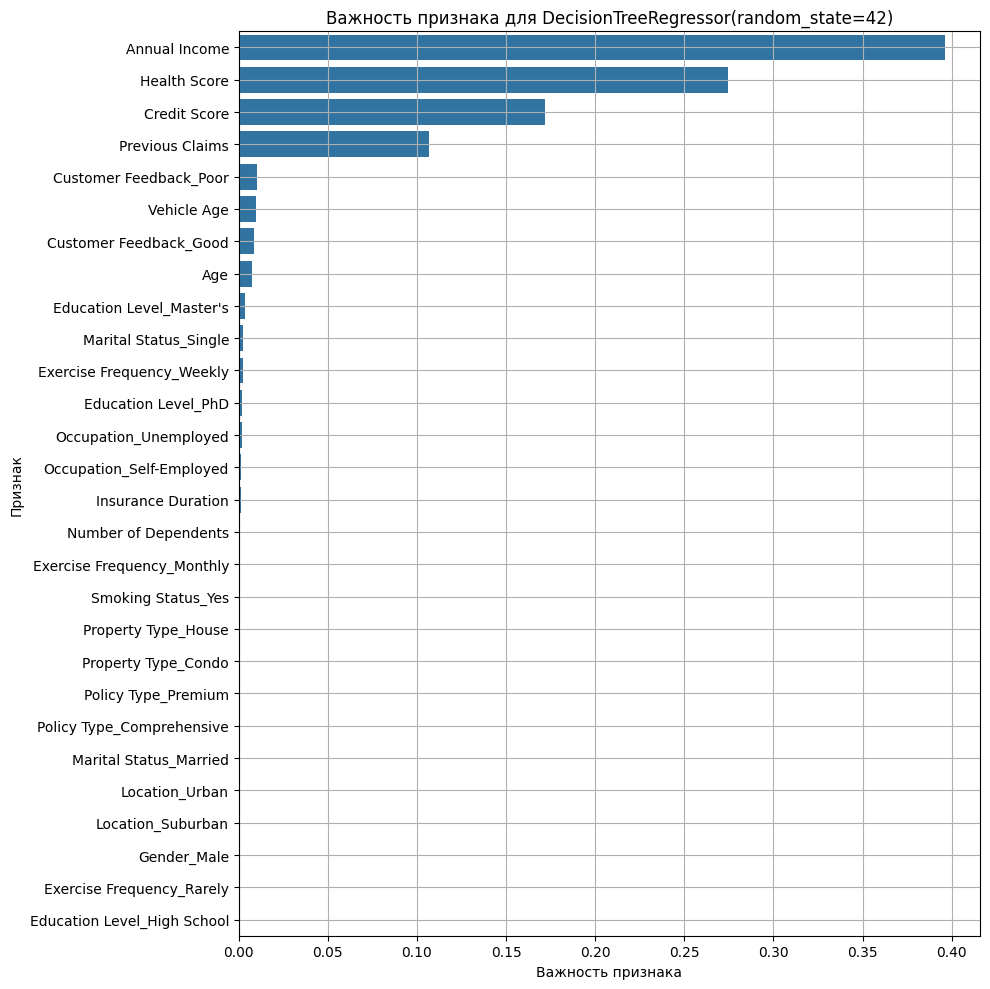

In [39]:
plot_feature_importance(best_model_dt, X_train, model_dt)

## RandomForestRegressor

In [40]:
param_grid_rf = {
    'max_depth': [None] + [i for i in range(1, 10, 2)],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'ccp_alpha': [0.01, 0.02, 0.03]
}

In [41]:
%%time

model_rf = RandomForestRegressor(random_state=42)     
best_model_rf = hyperparameter_search(model_rf, param_grid_rf, X_train, y_train)
metrics_rf, y_pred_rf = evaluate_model(best_model_rf, X_test, y_test)

Лучшие гиперпараметры для RandomForestRegressor(random_state=42): {'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 9, 'ccp_alpha': 0.03}
CPU times: total: 38.4 s
Wall time: 6min 2s


In [42]:
# Подсчет метрик
df_metrics_rf = pd.DataFrame([metrics_rf])
df_metrics_rf

,MAE,MSE,RMSE,R2
0,645.481,713719.69,844.819,0.033


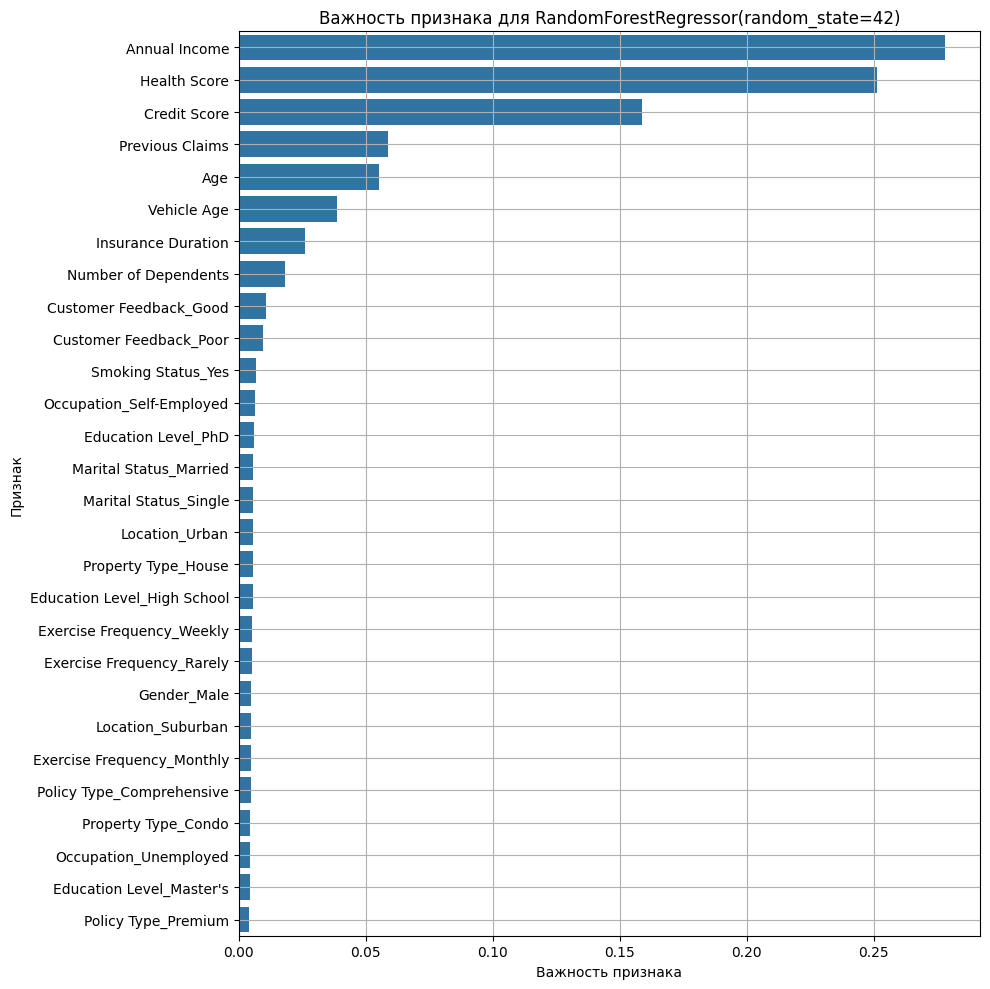

In [43]:
plot_feature_importance(best_model_rf, X_train, model_rf)

## AdaBoostRegressor

In [44]:
param_grid_ab = {
    'learning_rate': [0.1, 0.2, 1.0],
    'n_estimators': [i for i in range(50, 201, 50)]
}

In [45]:
%%time

model_ab = AdaBoostRegressor(random_state=42)     
best_model_ab = hyperparameter_search(model_ab, param_grid_ab, X_train, y_train)
metrics_ab, y_pred_ab = evaluate_model(best_model_ab, X_test, y_test)

Лучшие гиперпараметры для AdaBoostRegressor(random_state=42): {'n_estimators': 50, 'learning_rate': 0.1}
CPU times: total: 19.9 s
Wall time: 3min 45s


In [46]:
# Подсчет метрик
df_metrics_ab = pd.DataFrame([metrics_ab])
df_metrics_ab

,MAE,MSE,RMSE,R2
0,735.858,792009.517,889.949,-0.073


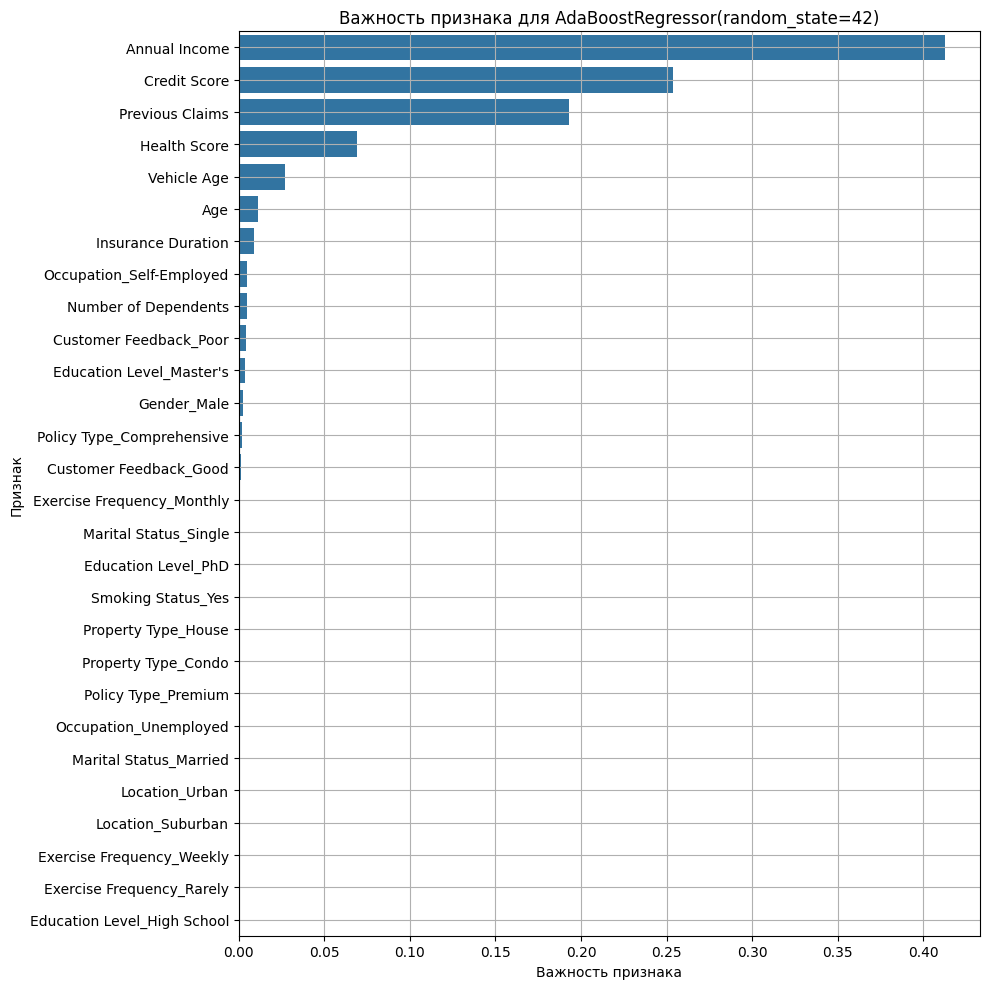

In [47]:
plot_feature_importance(best_model_ab, X_train, model_ab)

## GradientBoostingRegressor

In [48]:
param_grid_gb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [i for i in range(50, 201, 50)],
    'max_depth': [None] + [i for i in range(1, 21, 5)],
    'criterion' : ['friedman_mse', 'squared_error'],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'ccp_alpha': [0.01, 0.03, 0.05]
}

In [49]:
%%time

model_gb = GradientBoostingRegressor(random_state=42)     
best_model_gb = hyperparameter_search(model_gb, param_grid_gb, X_train, y_train)
metrics_gb, y_pred_gb = evaluate_model(best_model_gb, X_test, y_test)

Лучшие гиперпараметры для GradientBoostingRegressor(random_state=42): {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_depth': 6, 'learning_rate': 0.1, 'criterion': 'friedman_mse', 'ccp_alpha': 0.01}
CPU times: total: 42.4 s
Wall time: 25min 18s


In [50]:
# Подсчет метрик
df_metrics_gb = pd.DataFrame([metrics_gb])
df_metrics_gb

,MAE,MSE,RMSE,R2
0,650.728,717881.152,847.279,0.027


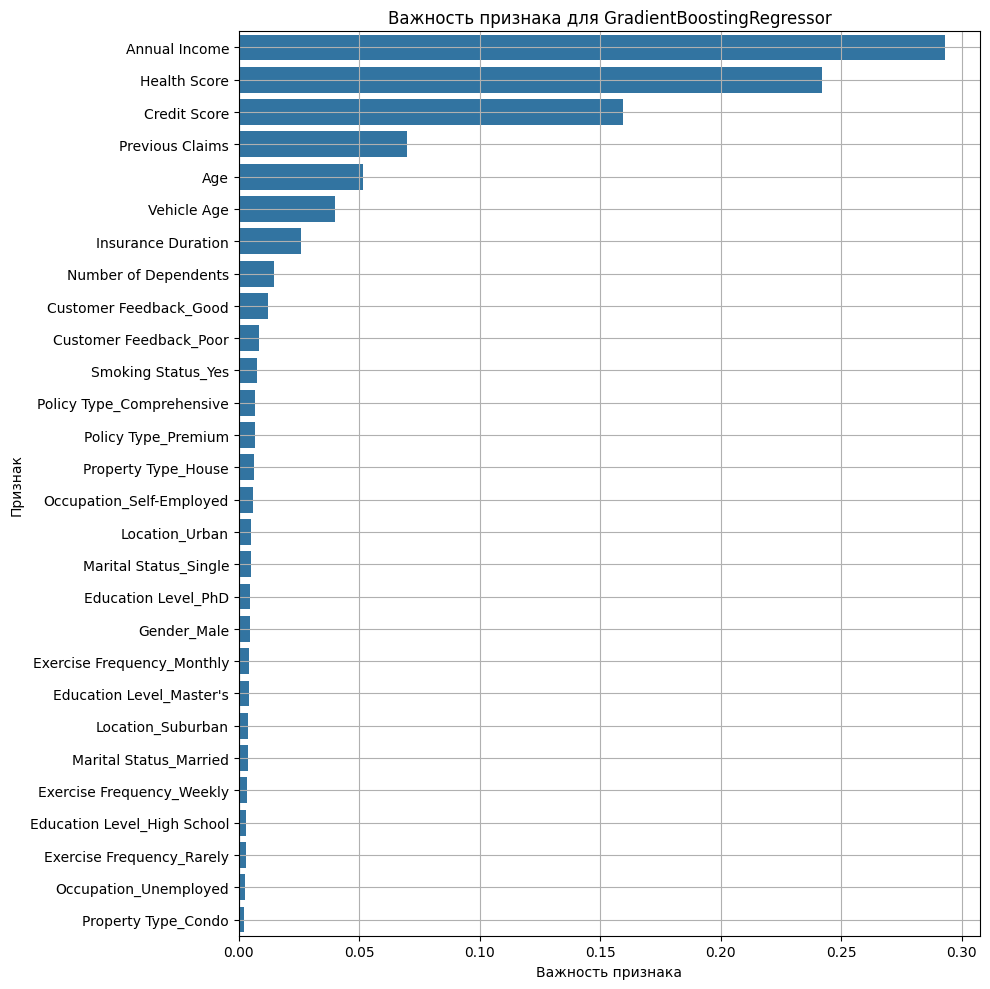

In [51]:
plot_feature_importance(best_model_gb, X_train, model_name='GradientBoostingRegressor')

## CatBoostRegressor

In [52]:
param_grid_cb = {
    'learning_rate': [0.1, 0.2, 0.3],
    'iterations': [i for i in range(100, 201, 50)],
    'depth': [None] + [i for i in range(1, 21, 5)],
    'l2_leaf_reg': [1, 5, 9]
}

In [53]:
%%time

model_cb = CatBoostRegressor(random_state=42)     
best_model_cb = hyperparameter_search(model_cb, param_grid_cb, X_train, y_train)
metrics_cb, y_pred_cb = evaluate_model(best_model_cb, X_test, y_test)

0:	learn: 863.4272547	total: 187ms	remaining: 18.6s
1:	learn: 860.6202547	total: 194ms	remaining: 9.5s
2:	learn: 859.0640085	total: 200ms	remaining: 6.47s
3:	learn: 857.5702864	total: 206ms	remaining: 4.94s
4:	learn: 856.8128558	total: 212ms	remaining: 4.04s
5:	learn: 856.5105511	total: 218ms	remaining: 3.42s
6:	learn: 856.3536722	total: 224ms	remaining: 2.98s
7:	learn: 855.9260973	total: 231ms	remaining: 2.66s
8:	learn: 855.2266277	total: 237ms	remaining: 2.4s
9:	learn: 855.0574497	total: 243ms	remaining: 2.19s
10:	learn: 854.9142708	total: 250ms	remaining: 2.02s
11:	learn: 854.3710176	total: 257ms	remaining: 1.89s
12:	learn: 854.2750197	total: 264ms	remaining: 1.76s
13:	learn: 854.0752572	total: 269ms	remaining: 1.66s
14:	learn: 853.9027510	total: 275ms	remaining: 1.56s
15:	learn: 853.6872807	total: 280ms	remaining: 1.47s
16:	learn: 853.5502663	total: 287ms	remaining: 1.4s
17:	learn: 853.3864933	total: 292ms	remaining: 1.33s
18:	learn: 852.7355247	total: 299ms	remaining: 1.28s
19:	le

In [54]:
# Подсчет метрик
df_metrics_cb = pd.DataFrame([metrics_cb])
df_metrics_cb

,MAE,MSE,RMSE,R2
0,651.598,718545.071,847.67,0.026


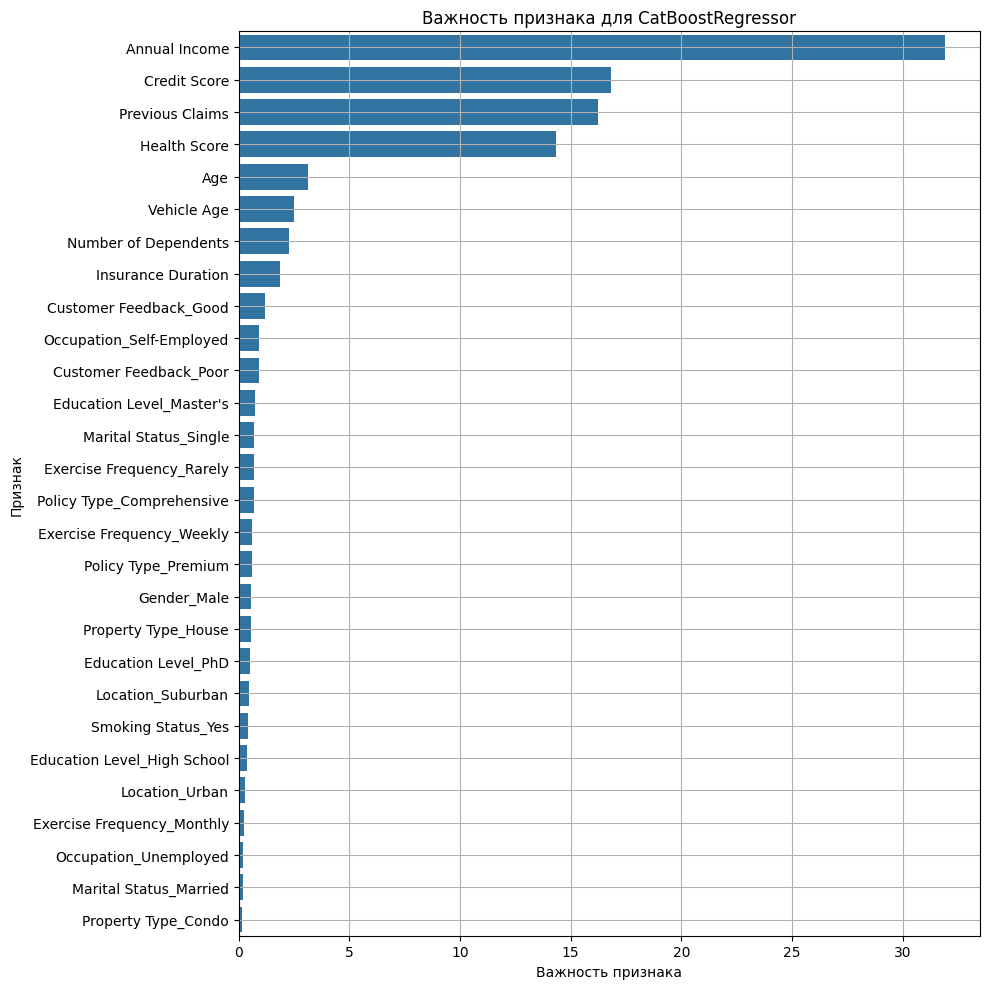

In [55]:
plot_feature_importance(best_model_cb, X_train, model_name='CatBoostRegressor')

## XGBRegressor

In [56]:
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [None] + [i for i in range(1, 31, 5)],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.25, 1.0]
}

In [57]:
%%time

model_xgb = XGBRegressor(objective='reg:squarederror', random_state=42)    
best_model_xgb = hyperparameter_search(model_xgb, param_grid_xgb, X_train, y_train)
metrics_xgb, y_pred_xgb = evaluate_model(best_model_xgb, X_test, y_test)

Лучшие гиперпараметры для XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...): {'n_estimators': 50, 'max_depth': None, 'learning_rate': 0.2, 'gamma': 0}
CPU times: total: 22.7 s
Wall time: 12min 12s


In [58]:
# Подсчет метрик
df_metrics_xgb = pd.DataFrame([metrics_xgb])
df_metrics_xgb

,MAE,MSE,RMSE,R2
0,651.955,721421.587,849.365,0.022


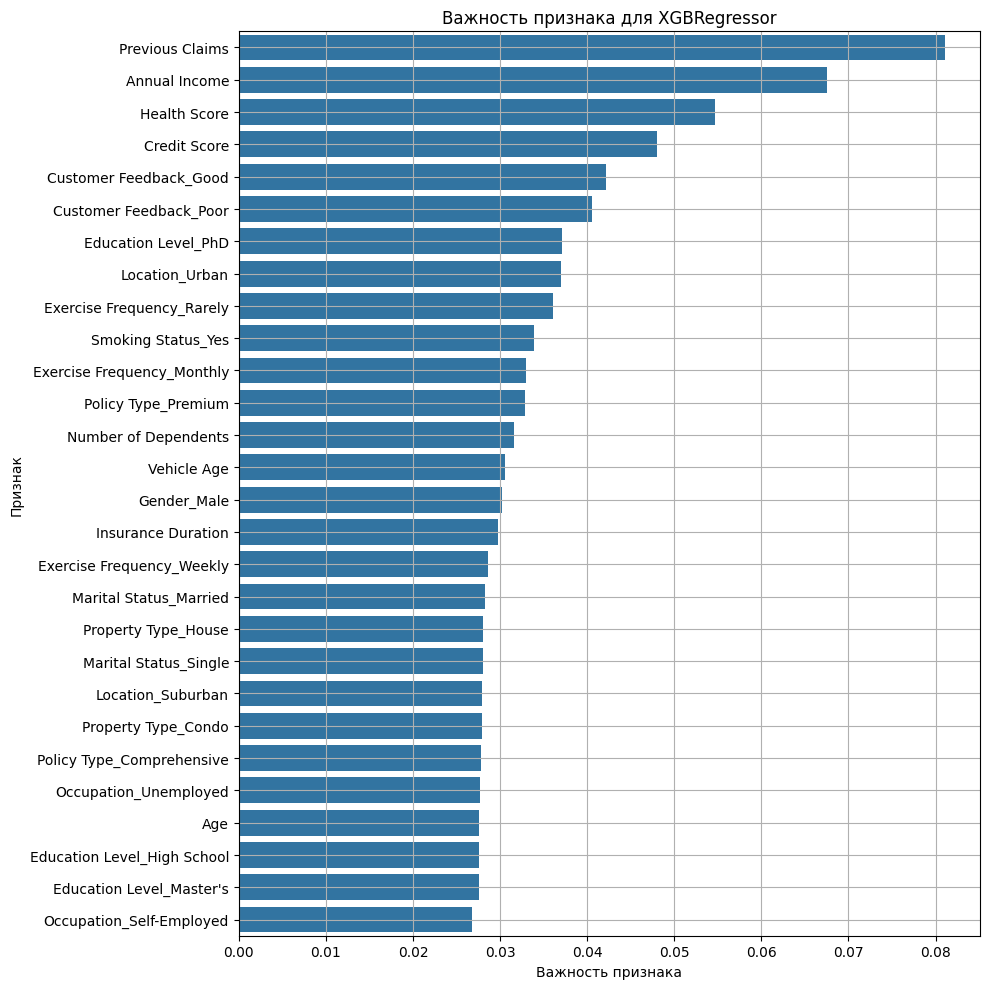

In [59]:
plot_feature_importance(best_model_xgb, X_train, model_name='XGBRegressor')

## Общая таблица полученных метрик качества

In [60]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(
    {'Метрики': [metrics_dt, 
                 metrics_rf,
                 metrics_ab,
                 metrics_gb,
                 metrics_cb,
                 metrics_xgb]
    },
    index=['DecisionTreeRegressor', 
           'RandomForestRegressor', 
           'AdaBoostRegressor', 
           'GradientBoostingRegressor', 
           'CatBoostRegressor', 
           'XGBRegressor']
)

,Метрики
DecisionTreeRegressor,"{'MAE': 648.02, 'MSE': 720280.043, 'RMSE': 848.693, 'R2': 0.024}"
RandomForestRegressor,"{'MAE': 645.481, 'MSE': 713719.69, 'RMSE': 844.819, 'R2': 0.033}"
AdaBoostRegressor,"{'MAE': 735.858, 'MSE': 792009.517, 'RMSE': 889.949, 'R2': -0.073}"
GradientBoostingRegressor,"{'MAE': 650.728, 'MSE': 717881.152, 'RMSE': 847.279, 'R2': 0.027}"
CatBoostRegressor,"{'MAE': 651.598, 'MSE': 718545.071, 'RMSE': 847.67, 'R2': 0.026}"
XGBRegressor,"{'MAE': 651.955, 'MSE': 721421.587, 'RMSE': 849.365, 'R2': 0.022}"


Видим, что из всех моделей, наилучшие результаты у `RandomForestRegressor: {'MAE': 645.481, 'MSE': 713719.69, 'RMSE': 844.819, 'R2': 0.033}`. Из моделей бустинга лучший результат у `GradientBoostingRegressor: {'MAE': 650.728, 'MSE': 717881.152, 'RMSE': 847.279, 'R2': 0.027}`. Возможно, если подать на вход в CatBoostRegressor категориальные признаки не кодированные, модель обучится лучше, так как CatBoost сам умеет обрабатывать их. 